# All your bass R belong to us

![](cat_bass.jpg)

## Why time series?

Time series analysis is useful when variance about a mean trend is correlated,
i.e., measurements are not iid. Think about weather trends: days with above
average temperature typically appear in a row, same with below average days.

Time series analysis of the number of threads posted per month in the Talk Bass
For Sale: Bass Guitars classified forum. This data spans from January, 2005,
to January, 2016.

## Imports

In [1]:
library(forecast)
library(ggplot2)

source('plotARIMA.R')
source('plotValidation.R')

Loading required package: zoo

Attaching package: ‘zoo’

The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric

Loading required package: timeDate
This is forecast 6.1 



## Load data

In [2]:
data.bass <- read.csv('thread_count_for_sale_bass_guitars.csv')
ts.bass <- ts(data.bass$count, frequency=12,
              start=c(data.bass$year[1], data.bass$month[1]))
print(ts.bass)

     Jan Feb Mar Apr May Jun Jul Aug Sep Oct Nov Dec
2005   0   0   0   2   0   0   0   6 135  97  96  97
2006 103 136 126 151 170 192 175 183 175 195 215 190
2007 246 264 294 320 271 322 291 316 298 306 356 276
2008 346 364 375 390 406 366 392 342 374 404 424 413
2009 458 465 461 421 467 450 500 498 519 567 509 531
2010 593 574 596 594 632 555 647 612 610 592 606 567
2011 725 583 757 661 630 610 697 703 663 649 702 585
2012 773 660 636 661 633 712 681 733 687 617 623 617
2013 707 658 771 716 624 631 692 692 698 732 638 570
2014 693 564 646 602 553 559 547 598 560 510 595 531
2015 580 595 577 545 553 568 575 608 586 633 591 601
2016 731                                            


September, 2005, is the first month with more than a few posted for sale threads.
Let's start our time series there under the assumption that anything earlier was
part of a trial run.

In [3]:
ts.bass <- ts(data.bass$count[9:length(ts.bass)], frequency=12,
              start=c(data.bass$year[9], data.bass$month[9]))

## Plot data

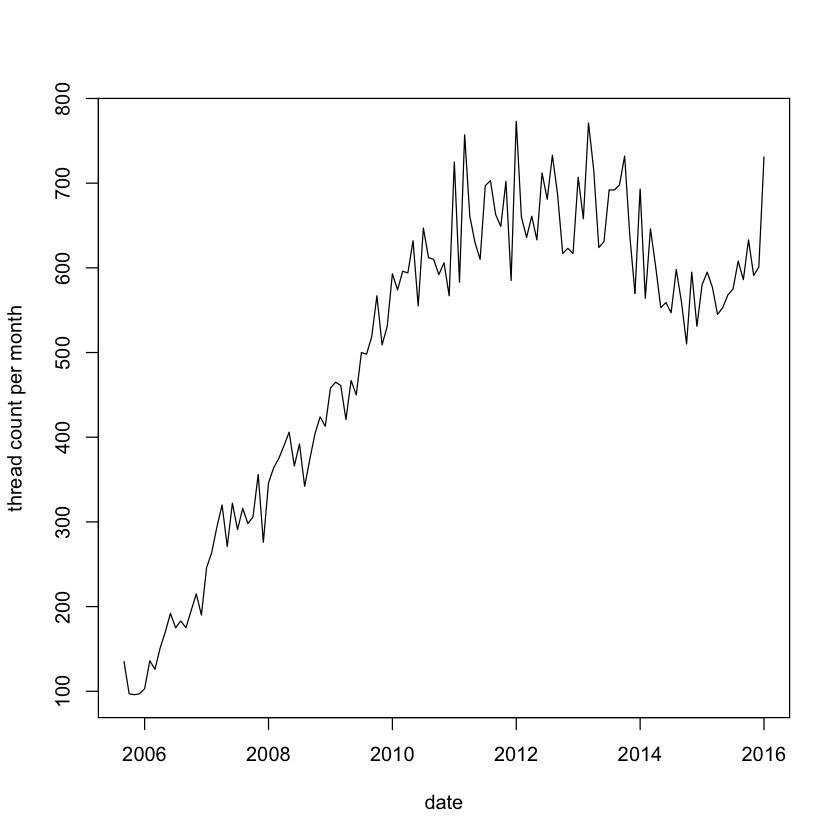

In [4]:
plot(ts.bass, ylab='thread count per month', xlab='date')

## [Auto regression](https://en.wikipedia.org/wiki/Autoregressive_model)

AR(p) model:  
$$X_t = c + \sum_{i = 1}^p \phi_i X_{t - i} + \epsilon_t$$

## [Moving aveverage](https://en.wikipedia.org/wiki/Moving-average_model)

MA(q) model:
$$X_t = \mu + \sum_{i = 1}^q \theta_i \epsilon_{t - i} + \epsilon_t$$

## Stationarity

The auto-regressive ("AR") and moving average ("MA") techniques assume the time series is stationary, 
i.e., its mean and/or variance is not changing with time. If we want to use these techniques, we have to make our time series stationary.

One technique to help achieve stationarity is to use differencing. This is the role of the
"I" in ARIMA modeling. More on that in a bit.

Let's jump right into the auto.arima function, see what we get, and try to get a sense of how we might intuit our way to the same answer. Some key steps to the auto.arima function:  
* Determine order of differencing, $d$, using a [Kwiatkowski-Phillips-Schmidt-Shin](https://en.wikipedia.org/wiki/KPSS_test) (KPSS) test for stationarity
* Determine $p$ and $q$ by minimizing the corrected [Akaike information criterion](https://en.wikipedia.org/wiki/Akaike_information_criterion) (AICc)
* Determinine seasonality from yearly/quarterly lags, still a bit mysterious to me.

In [5]:
arima.bass <- auto.arima(ts.bass, approximation=FALSE) #approximation=FALSE: computes maximum likelihood
arima.bass

Series: ts.bass 
ARIMA(1,1,1)(2,0,0)[12] with drift         

Coefficients:
         ar1      ma1    sar1    sar2   drift
      -0.246  -0.4740  0.1762  0.2967  4.5468
s.e.   0.145   0.1365  0.0848  0.0882  2.6247

sigma^2 estimated as 1682:  log likelihood=-638.24
AIC=1288.49   AICc=1289.2   BIC=1305.41

The best fit model is ARIMA(p, d, q) model has:  
$$(p, d, q) = (1, 1, 1),$$  
where $p$ is the order of the autoregressive model, $d$ is the order of differencing, and $q$ is the order of the moving average model. Additionally, the seasonal component of autoregression, $P$ is determined to be 2. An ARIMA(0,0,0)(2,0,0) model would give:  
$$X_t = c + \theta_1 X_{t - 12} + \theta_2 X_{t - 24} + \epsilon_t.$$

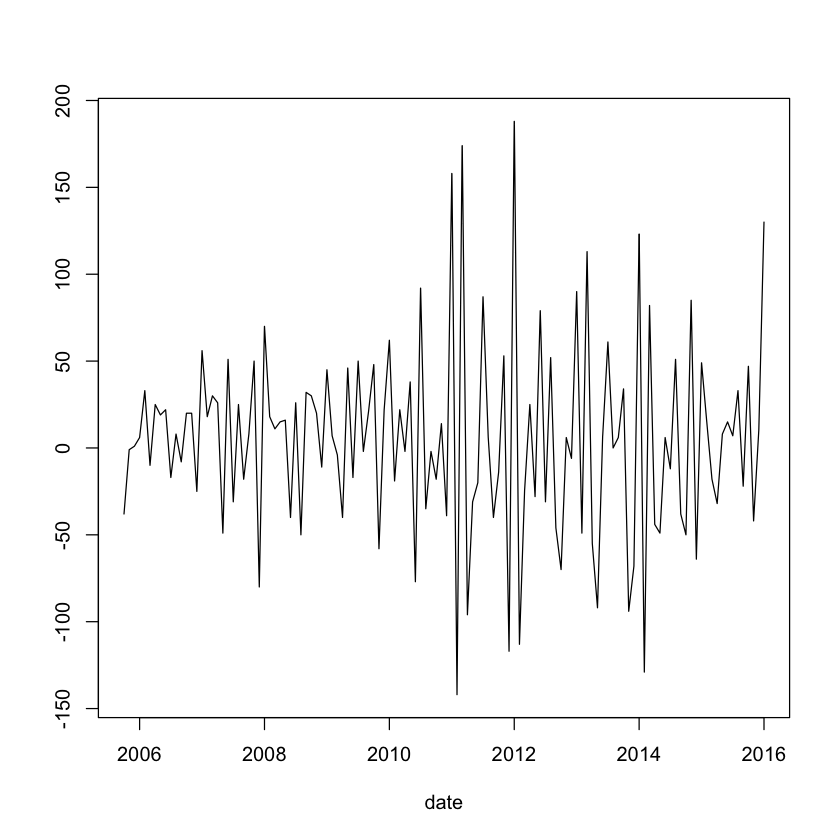

In [6]:
ts.bass.diff1 <- diff(ts.bass, differences=1)
plot(ts.bass.diff1, ylab='', xlab='date')

This looks pretty good. What do the autocorrelation and partial auto correlation plots look like?

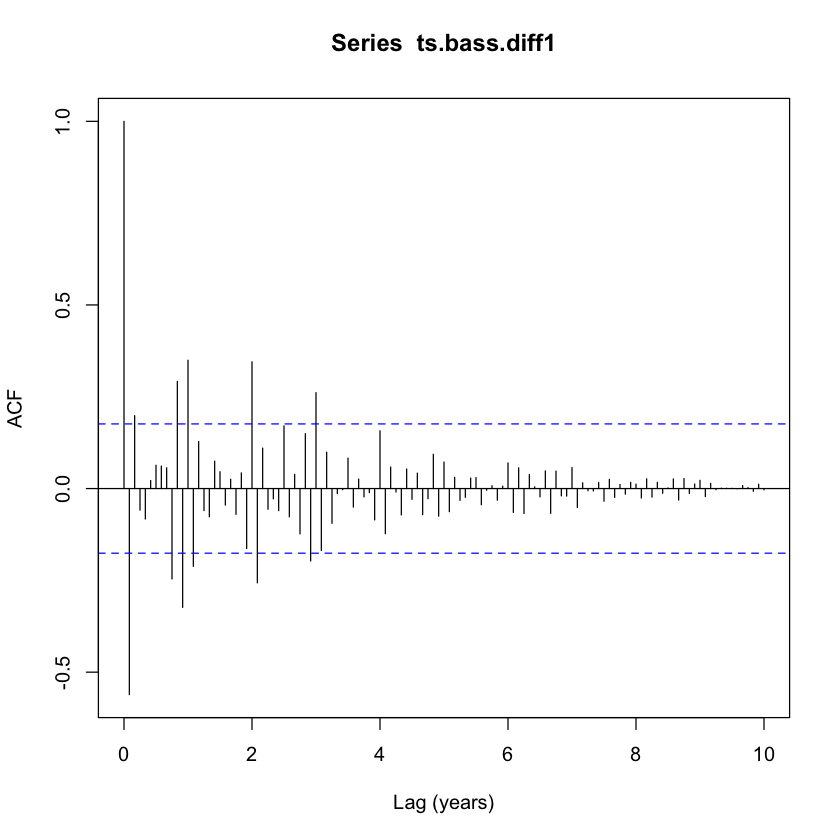

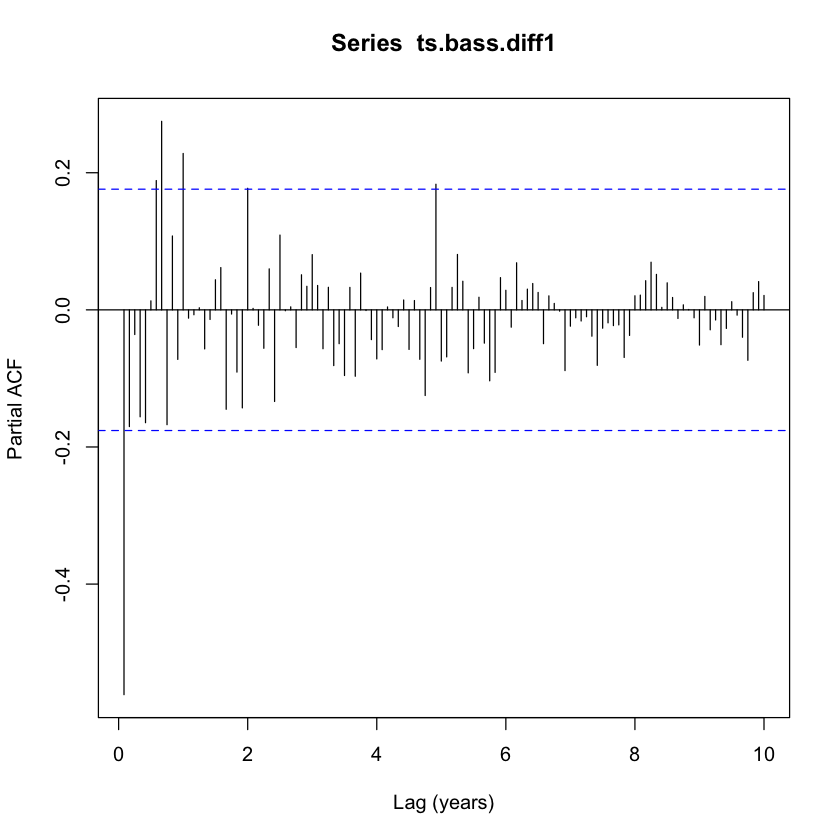

In [7]:
acf(ts.bass.diff1, lag=120, xlab="Lag (years)")
pacf(ts.bass.diff1, lag=120, xlab="Lag (years)")

Simple heuristic: the autocorrelation function tells you what $q$ and $Q$ should be and the partial autocorrelation tells you what $p$ and $P$ should be. Somewhat annoyingly, the autocorrelation plot shows lag 0 and the partial autocorrelation does not (autocorrelation at lag 0 is identically 1).

We see significant autocorrelation at lags one and two-ish, which corresponds well to the fact that our model chose $q = 1$. We also see decaying periodicity, which suggests a seasonal component.

We find significant partial autocorrelation at lags 1, 7, and 8. But AICc, which explicitly punishes the addition of free parameters, doesn't recommend extending $p$ out to 8, so $p = 1$. We also see significant partial autocorrelation at lags 12, 24, and 60. Again, AICc doesn't think it's worth it to include seasonal lags all the way out to 5 years, so $Q=2$.

## Forecasting

What will the next twelve months of bass sales look like in the Talk Bass classifieds? Blue curve is point forecast, dark grey is the 80% confidence interval, and light grey is a the 95% confidence interval.

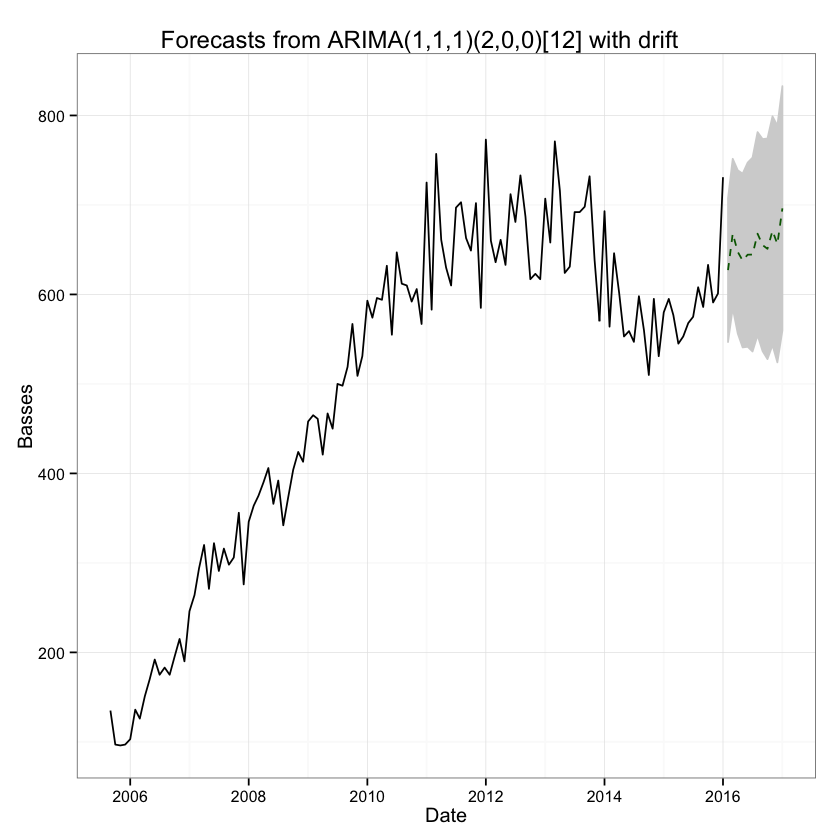

In [8]:
forecast.bass <- forecast(arima.bass, h=12)
print(plotARIMA(forecast.bass, plot.mean=TRUE))

## Validation

I wouldn't call myself an expert, but a normal cross validation approach doesn't seem to make sense for a time series because the prediction at one point depends on the preceding values. We can't just hold out a random set of values and simply build the model without them, we'd lose not only our examples, but our features as well.

The method I've employed is to train the time series model up through January 2015, make a forecast for the proceeding year, and measure how well the forecast projects the data collected during 2015.

In [9]:
ts.bass.validation <- ts(ts.bass[0:(length(ts.bass)-12)], frequency=12,
                         start=c(data.bass$year[9], data.bass$month[9]))
arima.bass.validation <- auto.arima(ts.bass.validation, approximation=FALSE)
arima.bass.validation.forecast <- forecast(arima.bass.validation, h=12)
arima.bass.validation

Series: ts.bass.validation 
ARIMA(1,1,1)(2,0,0)[12]                    

Coefficients:
          ar1      ma1    sar1    sar2
      -0.2589  -0.4623  0.2124  0.3319
s.e.   0.1544   0.1467  0.0894  0.0980

sigma^2 estimated as 1680:  log likelihood=-577.11
AIC=1164.21   AICc=1164.78   BIC=1177.81

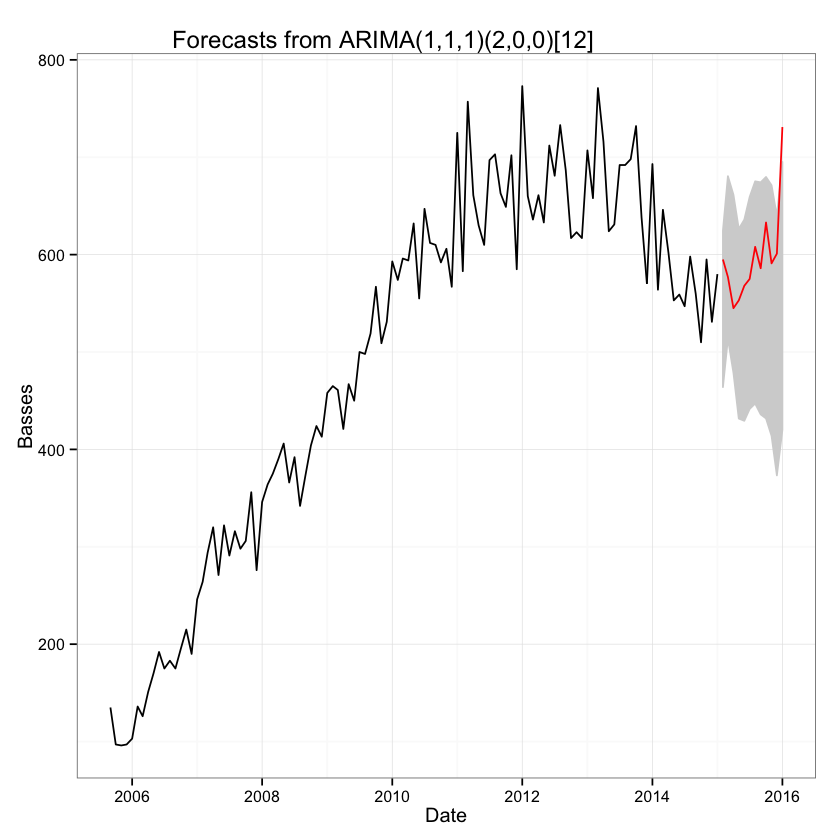

In [10]:
plotValidation(arima.bass.validation.forecast, ts.bass)

## Define our own ARIMA model

Our model over the full data set had a drift term. What if we want to build an ARIMA model with specified (p,d,q) and (P,D,Q)?

In [11]:
arima.bass.pdq <- arima.bass$arma[c(1,6,2)]
arima.bass.PDQ <- arima.bass$arma[c(3,7,4)]
arima.bass.validation2 <- Arima(ts.bass.validation, order=arima.bass.pdq,
                                seasonal=arima.bass.PDQ, include.drift=TRUE)
arima.bass.validation2.forecast <- forecast(arima.bass.validation2, h=12)
arima.bass.validation2

Series: ts.bass.validation 
ARIMA(1,1,1)(2,0,0)[12] with drift         

Coefficients:
          ar1      ma1    sar1    sar2   drift
      -0.2447  -0.4909  0.2010  0.3176  3.3639
s.e.   0.1509   0.1396  0.0901  0.0993  2.8284

sigma^2 estimated as 1667:  log likelihood=-576.47
AIC=1164.94   AICc=1165.74   BIC=1181.25

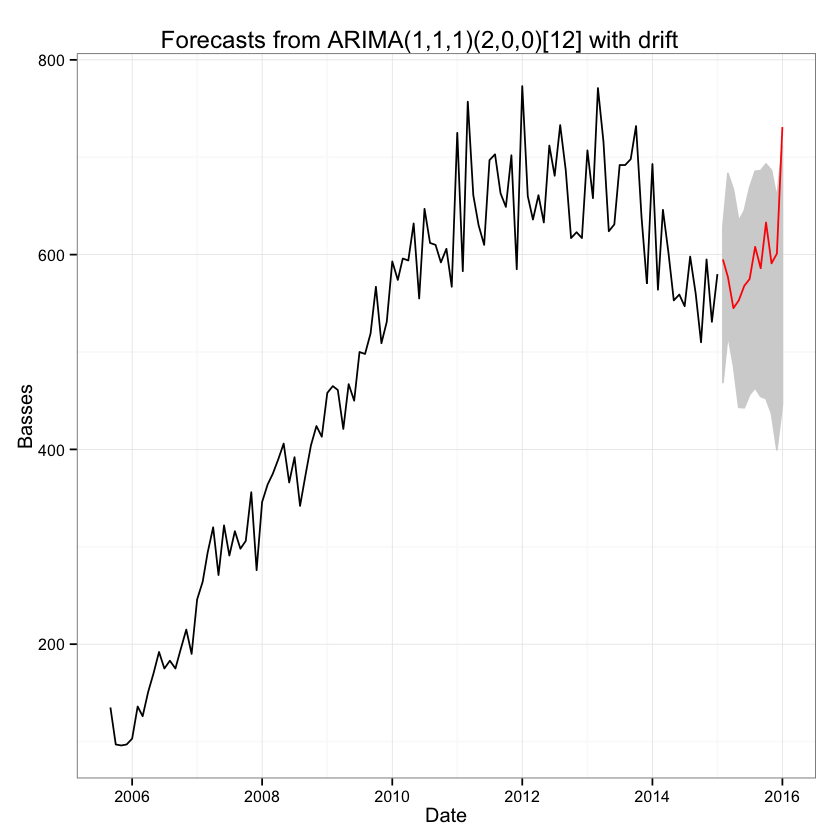

In [12]:
plotValidation(arima.bass.validation2.forecast, ts.bass)

## Other models

ARIMA isn't the only game in town for time series modeling. Holt-Winters is another model that uses [exponential smoothing](https://en.wikipedia.org/wiki/Exponential_smoothing) (beyond the scope of this tutorial). In our case, it seems to over emphasize the downward trend starting in 2013 compared to the ARIMA models and the measured 2015 data.

In [13]:
hw.bass.validation <- HoltWinters(ts.bass.validation)
hw.bass.validation.forecast <- forecast(hw.bass.validation, h=12)
hw.bass.validation

Holt-Winters exponential smoothing with trend and additive seasonal component.

Call:
HoltWinters(x = ts.bass.validation)

Smoothing parameters:
 alpha: 0.2855615
 beta : 0.09507258
 gamma: 0.3062201

Coefficients:
          [,1]
a   559.249114
b    -5.262128
s1  -35.011549
s2   23.451729
s3   -7.888689
s4  -35.931793
s5  -23.303449
s6    1.292109
s7   15.998052
s8   -6.452318
s9  -21.651516
s10 -10.485966
s11 -61.012752
s12  32.179238

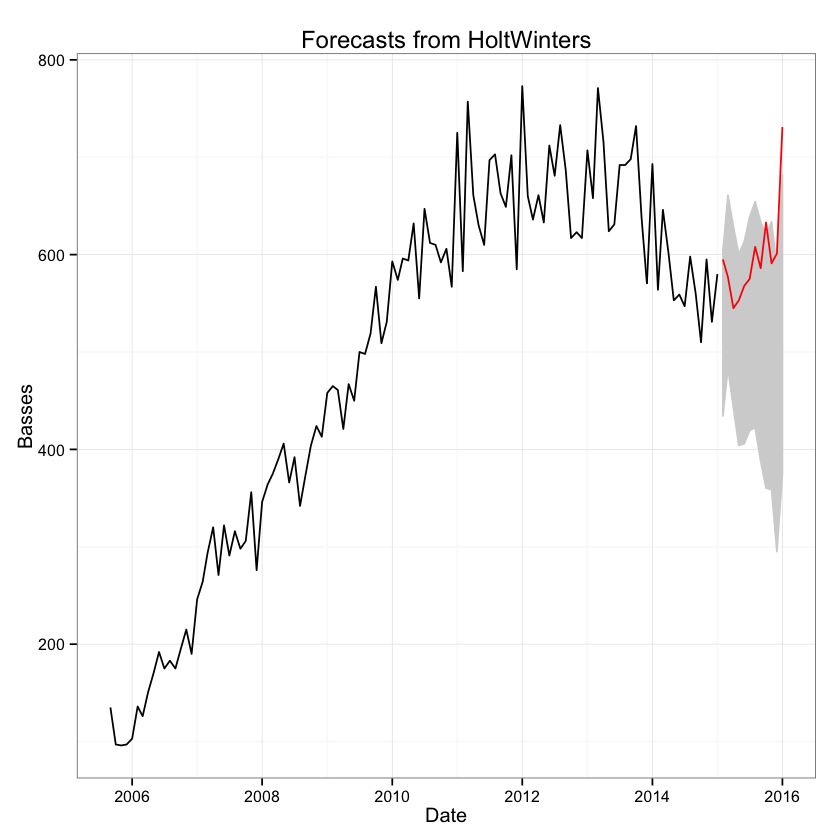

In [14]:
plotValidation(hw.bass.validation.forecast, ts.bass)